# Setting Directory and Creating the CSV file

## Imports & global config  

In [6]:
# install requirements – only if packages are missing
# !pip install pandas numpy matplotlib tqdm pyyaml --quiet

from pathlib import Path
import textwrap
import pandas as pd
from itertools import product
import random
import csv
import numpy as np
import dataclasses
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pandas.errors import ParserError
import pathlib
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [7]:
USE_DRIVE = True      # flip to False on local

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = Path("/content/drive/MyDrive/market_maker_demo")
else:
    BASE_DIR = Path(".") / "market_maker_demo"

BASE_DIR.mkdir(exist_ok=True, parents=True)
print("Project folder :", BASE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project folder : /content/drive/MyDrive/market_maker_demo


## Downloading BTC_1sec Limit Order Book

In [8]:
# Install dependencies as needed
# !pip -q install kagglehub[pandas-datasets]

# A utility that downloads + makes a visible copy
def fetch_btc_1sec(local_dir="/content") -> pd.DataFrame:
    # Pull from Kaggle (first call downloads, later calls hit the cache)
    df_raw = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "martinsn/high-frequency-crypto-limit-order-book-data",
        "BTC_1sec.csv",
    )

    # Add the columns your project expects
    df_raw["best_bid"] = df_raw["midpoint"] - df_raw["spread"] / 2
    df_raw["best_ask"] = df_raw["midpoint"] + df_raw["spread"] / 2
    df_raw["mid"]      = df_raw["midpoint"]
    df_raw["t"]        = range(len(df_raw))

    # Save a visible copy
    vis_dir  = pathlib.Path(local_dir)
    vis_dir.mkdir(parents=True, exist_ok=True)
    out_csv  = vis_dir / "BTC_1sec.csv"
    df_raw.to_csv(out_csv, index=False)
    print(f"Saved : {out_csv.resolve()}")

    # Return the trimmed dataframe ready for analysis
    return df_raw[["t", "best_bid", "best_ask", "mid"]]

df = fetch_btc_1sec()

df.head()


<ipython-input-8-72821a0878eb>:7: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_raw = kagglehub.load_dataset(


100%|██████████| 317M/317M [00:04<00:00, 70.8MB/s]

Extracting zip of BTC_1sec.csv...


Saved : /content/BTC_1sec.csv


,t,best_bid,best_ask,mid
0,0,56035.99,56036.0,56035.995
1,1,56035.99,56036.0,56035.995
2,2,56035.99,56036.0,56035.995
3,3,56035.99,56036.0,56035.995
4,4,56035.99,56036.0,56035.995


## Write requirements.txt & create experiments.csv if missing

In [9]:
EXP = BASE_DIR / "experiments.csv"
REQ = BASE_DIR / "requirements.txt"

# 2-A: requirements.txt (only first run)
if not REQ.exists():
    REQ.write_text(textwrap.dedent("""\
        pandas
        numpy
        matplotlib
        tqdm
        pyyaml
    """).strip())
    print("requirements.txt written")

# 2-B: experiments.csv header only
param_cols  = ["asset","freq","spread_mult","fill_prob",
               "max_inventory","inventory_penalty","fee_per_share","slip_ppv"]
metric_cols = ["train_sharpe","val_sharpe","oos_sharpe","max_dd","turnover"]
header      = param_cols + metric_cols

if not EXP.exists():
    pd.DataFrame(columns=header).to_csv(EXP, index=False)
    print("Created empty experiments.csv with header only")
else:
    print("experiments.csv already exists – leaving untouched")


experiments.csv already exists – leaving untouched


## Create 40 different parameter permutatations

In [22]:
RUN = True         # flip to True ONCE, then back to False

if RUN:
    grid = {
        "spread_mult"      : [0.3, 0.5, 0.8, 1.2],          # 4
        "fill_prob"        : [0.6, 0.75, 0.9],              # 3
        "max_inventory"    : [20, 50, 100],                 # 3
        "inventory_penalty": [0.0001, 0.001, 0.002, 0.005], # 4
    }
    full = list(product(*grid.values()))    # 4×3×3×4 = 144
    random.shuffle(full)                    # mix the order

    # stratified down-sample: keep 10 combos per spread_mult value
    target = 40
    bucket = {sm: [] for sm in grid["spread_mult"]}
    for combo in full:
        sm = combo[0]
        if len(bucket[sm]) < target // len(grid["spread_mult"]):
            bucket[sm].append(combo)
        if sum(len(v) for v in bucket.values()) == target:
            break
    sample40 = list(v for combos in bucket.values() for v in combos)

    # de-dupe against existing rows
    df = pd.read_csv(EXP)
    already = set(zip(df.asset, df.freq,
                      df.spread_mult, df.fill_prob,
                      df.max_inventory, df.inventory_penalty))
    new_rows = [("ADA","1min",*c) for c in sample40
                if ("ADA","1min",*c) not in already]

    with open(EXP, "a", newline="") as f:
        w = csv.writer(f)
        for r in new_rows:
            w.writerow(list(r) + [0.0002, 0.00005] + [""]*len(metric_cols))

    print(f"Added {len(new_rows)} balanced ADA grid rows")


Added 40 balanced ADA grid rows


## For Deduplication of any row

In [23]:
df = pd.read_csv(EXP)
dedup = df.drop_duplicates(subset=param_cols, keep='first')
dedup.to_csv(EXP, index=False)
print("Deduplicated: now", len(dedup), "rows")


Deduplicated: now 40 rows


# To Purge the experiments.csv file

In [21]:
# Ensure param_cols and metric_cols are defined (from Cell 2)
header = param_cols + metric_cols

# Overwrite experiments.csv with just the header row (no data)
pd.DataFrame(columns=header).to_csv(EXP, index=False)
print("experiments.csv cleared; now contains only the header row")


experiments.csv cleared; now contains only the header row


# Running the Market Maker

## Testing on first row of parameters

In [24]:
exp_df = pd.read_csv(EXP)
row_idx = exp_df[exp_df["train_sharpe"].isna()].index.min()

if pd.isna(row_idx):
    print("All experiments scored!")
    params = None          # safeguard later cells
else:
    params = exp_df.loc[row_idx, param_cols].to_dict()
    # cast numerics
    for k in ["spread_mult","fill_prob","inventory_penalty",
              "fee_per_share","slip_ppv"]:
        params[k] = float(params[k])
    params["max_inventory"] = int(params["max_inventory"])
    params["data_path"]     = f"{params['asset']}_{params['freq']}.csv"
    print("Running row", row_idx, ":", params)


Running row 0 : {'asset': 'ADA', 'freq': '1min', 'spread_mult': 0.3, 'fill_prob': 0.75, 'max_inventory': 50, 'inventory_penalty': 0.005, 'fee_per_share': 0.0002, 'slip_ppv': 5e-05, 'data_path': 'ADA_1min.csv'}


## Data loader

In [25]:
import pandas as pd, numpy as np

def load_lob(path):
    try:
        df = pd.read_csv(path)
    except pd.errors.ParserError:
        print(f"ParserError in {path} – skipping malformed rows")
        df = pd.read_csv(
            path,
            engine="python",
            on_bad_lines="skip",   # the magic flag
        )

    # normalise schema → [t, best_bid, best_ask, mid]
    if {"midpoint","spread"}.issubset(df.columns):
        df["best_bid"] = df["midpoint"] - df["spread"]/2
        df["best_ask"] = df["midpoint"] + df["spread"]/2
        df["mid"]      = df["midpoint"]
    else:
        df["mid"] = (df["best_bid"] + df["best_ask"]) / 2

    df["t"] = np.arange(len(df))
    return df[["t","best_bid","best_ask","mid"]]


# load the actual LOB for this experiment
LOB = load_lob(params["data_path"])
print(f"Loaded {len(LOB):,} rows from {params['data_path']}")
display(LOB.head())



Loaded 17,109 rows from ADA_1min.csv


,t,best_bid,best_ask,mid
0,0,1.1620,1.1621,1.16205
1,1,1.1669,1.1691,1.16800
2,2,1.1747,1.1759,1.17530
3,3,1.1650,1.1667,1.16585
4,4,1.1721,1.1730,1.17255


## Core dataclasses

In [26]:
@dataclasses.dataclass
class Config:
    fixed_spread:      float
    max_inventory:     int
    inventory_penalty: float
    fee_per_share:     float
    slip_ppv:          float
    fill_prob:         float

@dataclasses.dataclass
class Trade:
    side:  str
    price: float
    qty:   int
    t:     int

@dataclasses.dataclass
class State:
    cash:       float = 0.0
    inventory:  int   = 0
    trades:     list  = dataclasses.field(default_factory=list)

    def mtm(self, px: float) -> float:
        return self.cash + self.inventory * px


## Market-maker logic

In [27]:
class MarketMaker:
    def __init__(self, cfg:Config):
        self.cfg, self.state = cfg, State()

    def _quote_prices(self, mid):
        inv_adj = self.cfg.inventory_penalty * self.state.inventory
        return (mid - self.cfg.fixed_spread/2 - inv_adj,
                mid + self.cfg.fixed_spread/2 - inv_adj)

    def step(self, row):
        bid_px, ask_px = self._quote_prices(row.mid)
        if bid_px >= row.best_bid and np.random.random() < self.cfg.fill_prob:
            self._exec("buy",  row.best_bid, 1, row.t)
        if ask_px <= row.best_ask and np.random.random() < self.cfg.fill_prob:
            self._exec("sell", row.best_ask, 1, row.t)

    def _exec(self, side, price, qty, t):
        fee  = self.cfg.fee_per_share*qty
        slip = self.cfg.slip_ppv*qty
        px   = price + slip if side=="buy" else price - slip
        self.state.cash      += (-px*qty if side=="buy" else px*qty) - fee
        self.state.inventory +=  qty if side=="buy" else -qty
        self.state.trades.append(Trade(side, px, qty, t))


## Walk-forward splitter & evaluator

In [28]:
def split_indices(n, train=0.6, val=0.2):
    i_tr = int(n*train)
    i_va = int(n*(train+val))
    return slice(0,i_tr), slice(i_tr,i_va), slice(i_va,n)

def run_backtest_split(df, cfg):
    sli_tr, sli_va, sli_os = split_indices(len(df))
    res = {}
    for tag, sl in zip(["train","val","oos"], [sli_tr,sli_va,sli_os]):
        mm, eq = backtest(df.iloc[sl].reset_index(drop=True), cfg)
        m = metr(eq)
        res[f"{tag}_sharpe"] = round(m["Sharpe"],3)
        if tag=="oos":
            res["max_dd"]  = round(m["MaxDD"],3)
            res["turnover"]= len(mm.state.trades)
    return res


## Backtesting

In [29]:
def backtest(book: pd.DataFrame, cfg: Config):
    mm = MarketMaker(cfg)
    mm.state.cash = 1.0          # start with 1 dollar to avoid divide-by-zero
    equity = [1.0]               # first equity sample
    for _, row in tqdm(book.iterrows(), total=len(book), leave=False):
        mm.step(row)
        equity.append(mm.state.mtm(row.mid))
    return mm, pd.Series(equity, name="equity")

def metr(eq: pd.Series) -> dict:
    pnl = eq.iloc[-1] - eq.iloc[0]
    rets = eq.pct_change().replace([np.inf, -np.inf], np.nan).dropna()
    sharpe = (np.sqrt(252) * rets.mean() / rets.std()) if len(rets) and rets.std()>0 else 0.0
    cummax = eq.cummax().replace(0, np.nan)           # avoid division by 0
    maxdd  = ((cummax - eq) / cummax).fillna(0).max()
    return {"PnL": round(pnl,3), "Sharpe": round(sharpe,3), "MaxDD": round(maxdd,3)}


## Auto-tune the spread   

In [30]:
median_spread = (LOB.best_ask - LOB.best_bid).median()
cfg = Config(
    fixed_spread      = median_spread * params["spread_mult"],
    max_inventory     = int(params["max_inventory"]),
    inventory_penalty = params["inventory_penalty"],
    fee_per_share     = params["fee_per_share"],
    slip_ppv          = params["slip_ppv"],
    fill_prob         = params["fill_prob"]
)
print(cfg)


Config(fixed_spread=0.00017999999999998017, max_inventory=50, inventory_penalty=0.005, fee_per_share=0.0002, slip_ppv=5e-05, fill_prob=0.75)


## Run the test backtest    

In [31]:
if params:
    cfg = Config(
        fixed_spread      = (LOB.best_ask-LOB.best_bid).median()*params["spread_mult"],
        max_inventory     = params["max_inventory"],
        inventory_penalty = params["inventory_penalty"],
        fee_per_share     = params["fee_per_share"],
        slip_ppv          = params["slip_ppv"],
        fill_prob         = params["fill_prob"]
    )

    metrics = run_backtest_split(LOB, cfg)
    print("Metrics:", metrics)

    # write back
    for k,v in metrics.items():
        exp_df.at[row_idx, k] = v
    exp_df.to_csv(EXP, index=False)
    print("experiments.csv updated (row", row_idx, ")")


  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

Metrics: {'train_sharpe': np.float64(0.535), 'val_sharpe': np.float64(1.653), 'oos_sharpe': np.float64(2.226), 'max_dd': 0.044, 'turnover': 4073}
experiments.csv updated (row 0 )


## Loop until all rows are scored

In [32]:
def evaluate_params(row):
    # 1) Build data path and load
    asset, freq = row["asset"], row["freq"]
    data_path = f"{asset}_{freq}.csv"
    lob = load_lob(data_path)

    # 2) Build config from row values
    cfg = Config(
        fixed_spread      = (lob.best_ask - lob.best_bid).median() * float(row["spread_mult"]),
        max_inventory     = int(row["max_inventory"]),
        inventory_penalty = float(row["inventory_penalty"]),
        fee_per_share     = float(row["fee_per_share"]),
        slip_ppv          = float(row["slip_ppv"]),
        fill_prob         = float(row["fill_prob"])
    )

    # 3) Run walk-forward backtest
    results = run_backtest_split(lob, cfg)
    return results

# Main sweep
exp_df = pd.read_csv(EXP)
# detect rows where train_sharpe is missing or blank
pending = exp_df["train_sharpe"].isna() | (exp_df["train_sharpe"].astype(str).str.strip() == "")
rows = exp_df[pending].index.tolist()

if not rows:
    print("All experiments scored!")
else:
    print(f"Scoring {len(rows)} pending rows…")
    for idx in tqdm(rows, desc="Sweeping grid"):
        row = exp_df.loc[idx]
        metrics = evaluate_params(row)
        # replace any NaNs with 0.0
        for k, v in metrics.items():
            if v is None or (isinstance(v, float) and math.isnan(v)):
                metrics[k] = 0.0
        # write back
        for k, v in metrics.items():
            exp_df.at[idx, k] = v

    # save once at the end
    exp_df.to_csv(EXP, index=False)
    print("Sweep complete — experiments.csv updated")


Scoring 39 pending rows…


Sweeping grid:   0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/10265 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

Sweep complete — experiments.csv updated


In [33]:
def slice_debug(idx):
    row = exp_df.loc[idx]
    fname = f"{row.asset}_{row.freq}.csv"
    lob   = load_lob(fname)
    cfg   = Config(
        fixed_spread      = (lob.best_ask-lob.best_bid).median()*row.spread_mult,
        max_inventory     = row.max_inventory,
        inventory_penalty = row.inventory_penalty,
        fee_per_share     = row.fee_per_share,
        slip_ppv          = row.slip_ppv,
        fill_prob         = row.fill_prob
    )
    mm, eq = backtest(lob, cfg)
    n = len(eq)
    sl_tr, sl_va, sl_os = slice(0,int(.6*n)), slice(int(.6*n),int(.8*n)), slice(int(.8*n),n)
    def stats(sli):
        seg   = eq[sli]
        rets  = seg.pct_change().dropna()
        mu, sd = rets.mean(), rets.std()
        return len(rets), seg.iloc[0], seg.iloc[-1], mu, sd
    print(f"Row {idx} → {row.asset}_{row.freq}")
    for tag, sli in zip(["train","val","oos"], [sl_tr,sl_va,sl_os]):
        nret, start,end,mu,sd = stats(sli)
        print(f"{tag:<5}: trades={len([t for t in mm.state.trades if sli.start<=t.t<sli.stop])}"
              f", obs={nret}, equity Δ={end-start:.4f}, μ={mu:.4e}, σ={sd:.4e}")

slice_debug(0)   # change 0 to any index with train Sharpe=0


  0%|          | 0/17109 [00:00<?, ?it/s]

Row 0 → ADA_1min
train: trades=11606, obs=10265, equity Δ=0.5329, μ=4.2225e-05, σ=1.1031e-03
val  : trades=4075, obs=3421, equity Δ=0.5619, μ=9.1650e-05, σ=8.9889e-04
oos  : trades=4082, obs=3421, equity Δ=1.2420, μ=1.3642e-04, σ=8.6303e-04


## Adding BTC_1sec and ETH_1min rows with best ADA-tuned parameters

In [34]:
exp_df = pd.read_csv(EXP)

# 1) Select best ADA 1-min row by highest out-of-sample Sharpe
ada_rows = exp_df[(exp_df["asset"] == "ADA") & (exp_df["freq"] == "1min")]
if ada_rows.empty:
    raise ValueError("No ADA rows found – run ADA sweep first.")
ada_best = ada_rows.sort_values("oos_sharpe", ascending=False).iloc[0]

# 2) Build two new rows with same hyper-params
param_values = ada_best[param_cols].to_list()   # keep spread_mult, fill_prob, etc.
new_rows = [
    ["BTC", "1sec"] + param_values[2:],   # clone knobs
    ["ETH", "1min"] + param_values[2:]
]

with open(EXP, "a", newline="") as f:
    writer = csv.writer(f)
    for r in new_rows:
        writer.writerow(r + [""] * len(metric_cols))

print("Added BTC_1sec and ETH_1min rows with ADA-tuned parameters")

Added BTC_1sec and ETH_1min rows with ADA-tuned parameters


## Testing ADA-tuned parameters on BTC_1sec and ETH_1min

In [35]:
df = pd.read_csv(EXP)

pending_mask = df["train_sharpe"].isna() | (df["train_sharpe"].astype(str).str.strip() == "")
pending_idx  = df[pending_mask].index.tolist()

if not pending_idx:
    print("All rows already scored.")
else:
    print(f"Scoring {len(pending_idx)} pending rows")
    for idx in pending_idx:
        row      = df.loc[idx]
        fname    = f"{row.asset}_{row.freq}.csv"

        if not os.path.exists(fname):
            print(f"{fname} missing skip row {idx}")
            continue

        try:
            metrics = evaluate_params(row)      # <- your existing helper
        except ParserError as e:
            print(f"CSV parse failed on {fname}: {e}. Skipping row {idx}")
            continue
        except Exception as e:
            print(f"Unexpected error on row {idx}: {e}. Skipping.")
            continue

        # write metrics back, sanitise NaNs
        for k, v in metrics.items():
            if v is None or (isinstance(v, float) and math.isnan(v)):
                v = 0.0
            df.at[idx, k] = v

    df.to_csv(EXP, index=False)
    print("experiments.csv updated")


Scoring 2 pending rows


  0%|          | 0/618436 [00:00<?, ?it/s]

  0%|          | 0/206146 [00:00<?, ?it/s]

  0%|          | 0/206146 [00:00<?, ?it/s]

  0%|          | 0/10266 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

  0%|          | 0/3422 [00:00<?, ?it/s]

experiments.csv updated


# Visual diagnostics - best-config summary plots

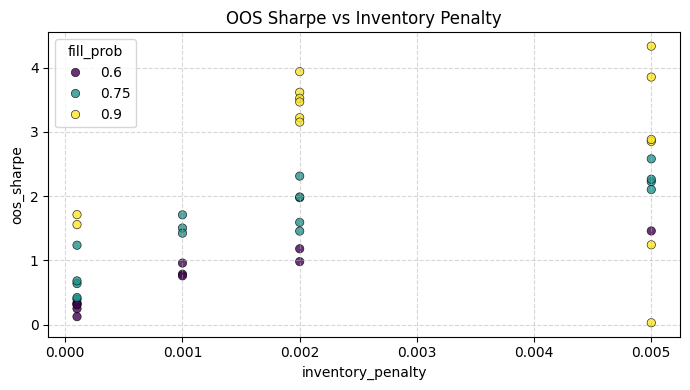

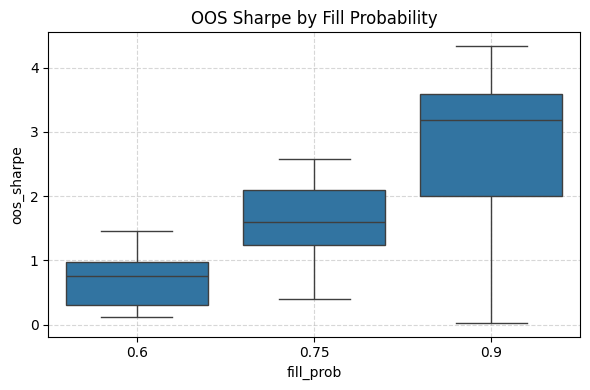

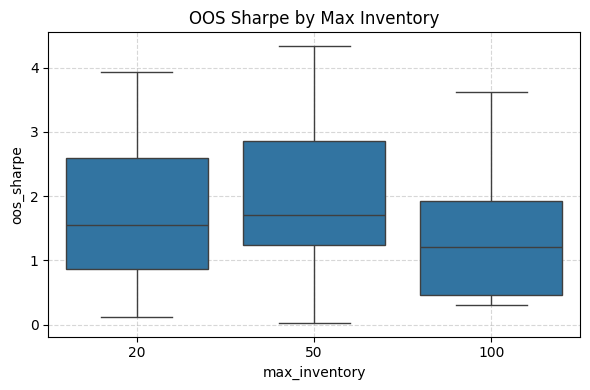

<ipython-input-37-841427ce0e53>:49: FutureWarning: The provided callable <function mean at 0x781eebbedf80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = df.pivot_table(


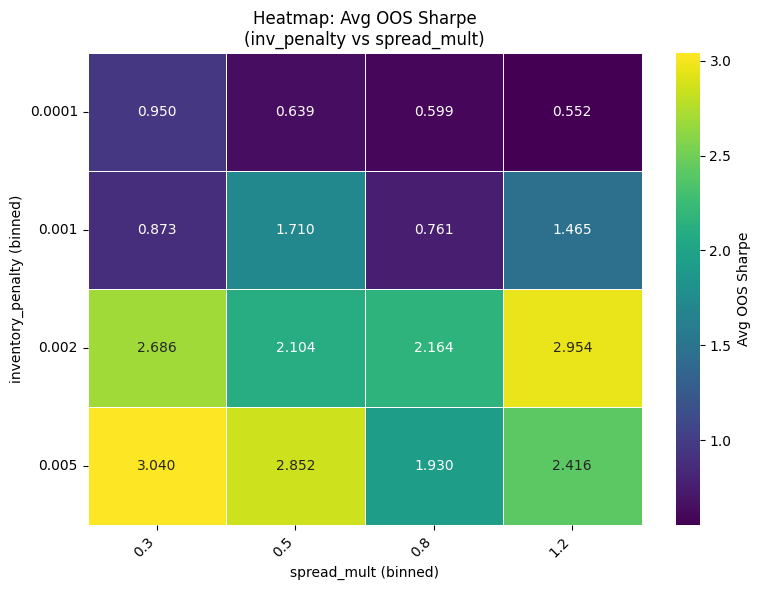

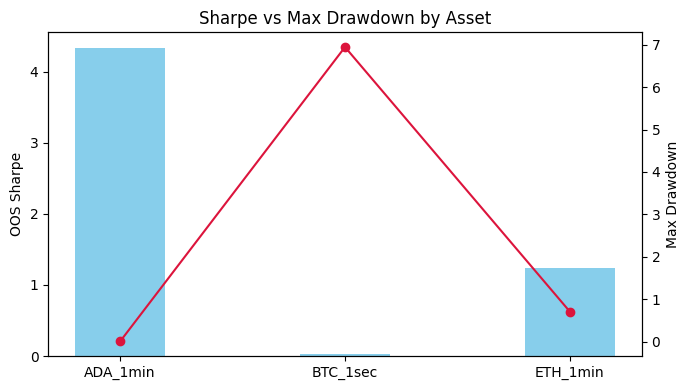

In [37]:
# 1) Loading the table
df = pd.read_csv(EXP)
if df["oos_sharpe"].dropna().empty:
    raise RuntimeError("No scored rows in experiments.csv.")

# 2) Scatter: OOS Sharpe vs Inventory_Penalty (hue=fill_prob)
plt.figure(figsize=(7, 4))
sns.scatterplot(
    x="inventory_penalty",
    y="oos_sharpe",
    hue="fill_prob",
    palette="viridis",
    data=df,
    edgecolor="k",
    linewidth=0.5,
    alpha=0.8
)
plt.title("OOS Sharpe vs Inventory Penalty")
plt.xlabel("inventory_penalty"); plt.ylabel("oos_sharpe")
plt.grid(ls="--", alpha=0.5); plt.tight_layout()
plt.show()

# 3) Box: OOS Sharpe by Fill_Prob
plt.figure(figsize=(6, 4))
sns.boxplot(x="fill_prob", y="oos_sharpe", data=df)
plt.title("OOS Sharpe by Fill Probability")
plt.xlabel("fill_prob"); plt.ylabel("oos_sharpe")
plt.grid(ls="--", alpha=0.5); plt.tight_layout()
plt.show()

# 4) Box: OOS Sharpe by Max_Inventory
plt.figure(figsize=(6, 4))
sns.boxplot(x="max_inventory", y="oos_sharpe", data=df)
plt.title("OOS Sharpe by Max Inventory")
plt.xlabel("max_inventory"); plt.ylabel("oos_sharpe")
plt.grid(ls="--", alpha=0.5); plt.tight_layout()
plt.show()

# 5) Heatmap: Avg OOS Sharpe (spread_mult vs inv_penalty)
if df["spread_mult"].nunique() > 6:
    df["spread_bin"] = pd.cut(df["spread_mult"].astype(float), bins=5, duplicates="drop")
else:
    df["spread_bin"] = df["spread_mult"].astype(float)
if df["inventory_penalty"].nunique() > 6:
    df["inv_bin"] = pd.cut(df["inventory_penalty"].astype(float), bins=5, duplicates="drop")
else:
    df["inv_bin"] = df["inventory_penalty"].astype(float)

heatmap_data = df.pivot_table(
    values="oos_sharpe",
    index="inv_bin",
    columns="spread_bin",
    aggfunc=np.mean
)
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f",
    cmap="viridis", linewidths=0.5,
    cbar_kws={"label": "Avg OOS Sharpe"}
)
plt.title("Heatmap: Avg OOS Sharpe\n(inv_penalty vs spread_mult)")
plt.xlabel("spread_mult (binned)"); plt.ylabel("inventory_penalty (binned)")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# 6) Sharpe vs Max Drawdown by Asset (bar + line)
summary = df[df["asset"].isin(["ADA", "BTC", "ETH"])].copy()
summary = summary.groupby(["asset", "freq"]).agg({
    "oos_sharpe": "max",
    "max_dd": "min"
}).reset_index()

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()
x = range(len(summary))

ax1.bar(x, summary["oos_sharpe"], width=0.4, color="skyblue", label="OOS Sharpe")
ax2.plot(x, summary["max_dd"], color="crimson", marker="o", label="Max DD")

ax1.set_ylabel("OOS Sharpe"); ax2.set_ylabel("Max Drawdown")
ax1.set_xticks(x)
ax1.set_xticklabels([f"{a}_{f}" for a, f in zip(summary["asset"], summary["freq"])])
ax1.set_title("Sharpe vs Max Drawdown by Asset")
fig.tight_layout(); plt.show()


## Unit-tests for key behaviours

In [38]:
def _test_quote_spread():
    # Ensure that our quoted ask–bid distance equals the configured spread
    q = MarketMaker(cfg)._quote_prices(100)
    assert math.isclose(q[1] - q[0], cfg.fixed_spread), "Spread mismatch"

def _test_inv_penalty():
    # Check that positive inventory skews bids down
    mm1 = MarketMaker(cfg)
    mm2 = MarketMaker(cfg)
    mm2.state.inventory = 10
    bid1 = mm1._quote_prices(100)[0]
    bid2 = mm2._quote_prices(100)[0]
    assert bid2 < bid1, "Inventory penalty not applied correctly"

_test_quote_spread()
_test_inv_penalty()
print("Unit-tests passed")


Unit-tests passed
